## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [2]:
# adding sample weights to evaluation causes the formulation probability 
# to differ, for sample weights != none, 
# probability is (sample_weight of same label)/(sum of sample weights)


# gini = 1 - sum(pi**2, pi in feature i)
def gini(sequence, sample_weight=None):
    
    values, cnt = np.unique(sequence, return_counts=True)
    gini_val = 0
    if sample_weight is None:
        p = cnt/sequence.shape[0]
        gini_val = np.sum([pi**2 for pi in p])
    
    else:
        weight_sum = sum(sample_weight)
        for value in values:
            idx = [idx for idx, x in enumerate(sequence) if x == value]
            count = np.sum(sample_weight[idx])
            gini_val += (count / weight_sum)**2
    
    return 1 - gini_val


# entropy = -sum(pj*log(pj))
def entropy(sequence, sample_weight=None):
    
    values, cnt = np.unique(sequence, return_counts=True)
    entropy_val = 0
    if sample_weight is None:
        p = cnt/sequence.shape[0]
        entropy_val = -1*np.sum([pj*np.log2(pj) for pj in p]) 
    
    else:
        weight_sum = sum(sample_weight)
        
        for value in values:
            idx = [idx for idx, x in enumerate(sequence) if x == value]
            count = np.sum(sample_weight[idx])
            entropy_val += -(count / weight_sum) * np.log2(count / weight_sum)
    
    return entropy_val

In [3]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [4]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [5]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [6]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
print(train_df.shape)
print(val_df.shape)

train_df.head() # 21 columns = 20 for x_data, 1 for y_data

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


In [7]:
x_train = train_df.iloc[:, 0:-1].values
y_train = train_df.iloc[:, -1].values
x_test = val_df.iloc[:, 0:-1].values
y_test = val_df.iloc[:, -1].values

## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [8]:
# describe nodes in the decision tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*, value=None):
        
        # for decision node
        self.feature = feature # the feature this node is divided with
        self.threshold = threshold # the threshold this node is divided with
        self.left = left # the left tree that is pointing to 
        self.right = right # the right tree that is pointing to
        
        # for leaf node
        self.value = value # the value of the tree
        
    # include a check, to see if this node is a leaf node or not
    def is_leaf_node(self):
        return self.value is not None

In [9]:
class DecisionTree():
    
    # initialization
    #******************************************
    def __init__(self, criterion='gini', max_depth=None, n_features=None, random=False):
        
        # record feature importance
        self.feat_list = []

        # mode selection
        self.criterion = criterion
        if criterion == 'gini':
            self.measure_func = gini
        else:
            self.measure_func = entropy
            
        # stopping criteria
        self.max_depth = max_depth
        
        # number of features, we are not using all of the features in the tree,
        # but just a subset of them, used for random forest
        self.n_features = n_features
        
        # use random feature or not
        self.random = random
        
        # keep access to he root of the node, used for traversing
        self.root = None

        
    # fitting with helper functions
    #****************************************
    def fit(self, x_data, y_data, sample_weight=None):
        if self.n_features is None:
            self.n_features = x_data.shape[1]
        
        self.sample_weight = sample_weight
        
        # _grow_tree will return the root of the tree in the end
        self.root = self._grow_tree(x_data, y_data)
            
    
    def _grow_tree(self, x_data, y_data, depth=0,*,other_side_ydata=None):
                                      # first set the depth to 0, while we are creating the tree
                                      # increase it by 1
        n_samples, n_feats = x_data.shape
        n_lables = len(np.unique(y_data))
        
        # 1. check the stopping critiria: meet max depth or is a leaf node
        # stop growing the tree and create a new node, then return it
        # find out the most common label inside the node
        if((self.max_depth is not None and depth >=self.max_depth) or n_lables==1 or n_lables==0):
            if n_lables==0:
                leaf_value = self._most_common_label(other_side_ydata)
                return Node(value=leaf_value)
            else:
                leaf_value = self._most_common_label(y_data)
                return Node(value=leaf_value)
        
        # pick the features we want to consider
        if self.random==False:
            feat_idxs = np.arange(n_feats)
        else:
            if self.n_features  == n_feats + 1:
                self.n_features -= 1
            feat_idxs = np.random.choice(np.arange(n_feats), self.n_features, replace=False)
        
        # 2. find the best split
        # if can't find feature and threshold, return the node
        best_feature, best_thresh = self._best_split(x_data, y_data, feat_idxs)
        if best_thresh is None or best_feature is None:
            leaf_value = self._most_common_label(y_data)
            return Node(value=leaf_value)
        self.feat_list.append(best_feature)

        # 3. create child nodes
        left_idxs, right_idxs = self._split(x_data[:, best_feature], best_thresh)
        
        # build the subtree recursively:
        # grow left tree
        left = self._grow_tree(x_data[left_idxs, :], y_data[left_idxs], depth+1)
        # grow right tree
        right = self._grow_tree(x_data[right_idxs, :], y_data[right_idxs], depth+1)
        
        return Node(best_feature, best_thresh, left, right)
        
        
    
    # find the best threshold/split among all possible thresholds/split
    def _best_split(self, x_data, y_data, feat_idxs):
        
        smallest_impurity = 100 # the impurity value
        split_idx, split_threshold = None, None
    
        # traverse all possible features
        for feat_idx in feat_idxs:
            x_column = x_data[:, feat_idx]
            # get all the possible threshold
            thresholds = np.unique(x_column)
            
            # traverse all possible thresholds
            for threshold in thresholds:
                # calculate the information gain
                impurity = self._information_gain(y_data, x_column, threshold)

                if impurity < smallest_impurity:
                    smallest_impurity = impurity
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold
    
    
    def _information_gain(self, y_data, x_column, threshold):
        
       
        # 1. create children
        # split data according to current threshold
        left_idxs, right_idxs = self._split(x_column, threshold)
        
        # if either side is empty, just return the the IG is 0(didn't do splitting)
        if(len(left_idxs)==0 or len(right_idxs)==0):
            return 100
        
        child_value = 0
        # 2. calculate the weighted avg. evaluation of children
        if self.sample_weight is None:
            # calculate the measure_func(gini or entropy) values of left and right
            value_l, value_r = self.measure_func(y_data[left_idxs]), self.measure_func(y_data[right_idxs])
            
            # calculate the weighted avg. value of children 
            n = len(y_data) # how many samples we have in y_data
            n_l, n_r = len(left_idxs), len(right_idxs) # how many samples we have in left and right nodes
            child_value = (n_l/n) * value_l + (n_r/n) * value_r
        else:
            # separate sample weights into left and right node
            left_weight_data = self.sample_weight[left_idxs]
            right_weight_data = self.sample_weight[right_idxs]
            
            # calculate the measure_func(gini or entropy) values of left and right
            value_l, value_r = self.measure_func(y_data[left_idxs], left_weight_data), self.measure_func(y_data[right_idxs], right_weight_data)
            
            left_weight_sum = np.sum(left_weight_data)
            right_weight_sum = np.sum(right_weight_data)
            weight_sum = np.sum(self.sample_weight)
            
            child_value = (left_weight_sum/weight_sum) * value_l + (right_weight_sum/weight_sum) * value_r
        
        return child_value
        
    # split the x_column data into left and right nodes
    def _split(self, x_column, threshold):
        # indices that go to the left tree
        left_idxs = np.argwhere(x_column < threshold).flatten()
        # indices that go to the right tree
        right_idxs = np.argwhere(x_column >= threshold).flatten()
        
        return left_idxs, right_idxs
    
    # count the most common value inside the node
    def _most_common_label(self, y):
        class_label, class_count = np.unique(y, return_counts= True)
        return class_label[np.argmax(class_count)]
        
    # prediction with helper function
    #****************************************    
    def predict(self, x_data):
        return np.array([self._traverse_tree(x, self.root) for x in x_data])
    
    def _traverse_tree(self, x, node):
        # x is data(row) being predicted, and node is where x is right now
        
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] < node.threshold:
            # pass the left side of the tree to be traverse
            return self._traverse_tree(x, node.left)
        # pass the right side of the tree to be traverse
        return self._traverse_tree(x, node.right)

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [10]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [11]:
clf_depth3.fit(x_train, y_train)
print("criterion=gini, max_depth=3, accuracy:", accuracy_score(clf_depth3.predict(x_test), y_test))

clf_depth10.fit(x_train, y_train)
print("criterion=gini, max_depth=10, accuracy:", accuracy_score(clf_depth10.predict(x_test), y_test))

criterion=gini, max_depth=3, accuracy: 0.92
criterion=gini, max_depth=10, accuracy: 0.93


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [12]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

In [13]:
clf_gini.fit(x_train, y_train)
print("criterion=gini, max_depth=3, accuracy:", accuracy_score(clf_gini.predict(x_test), y_test))

clf_entropy.fit(x_train, y_train)
print("criterion=entropy, max_depth=3, accuracy:", accuracy_score(clf_entropy.predict(x_test), y_test))

criterion=gini, max_depth=3, accuracy: 0.92
criterion=entropy, max_depth=3, accuracy: 0.9333333333333333


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

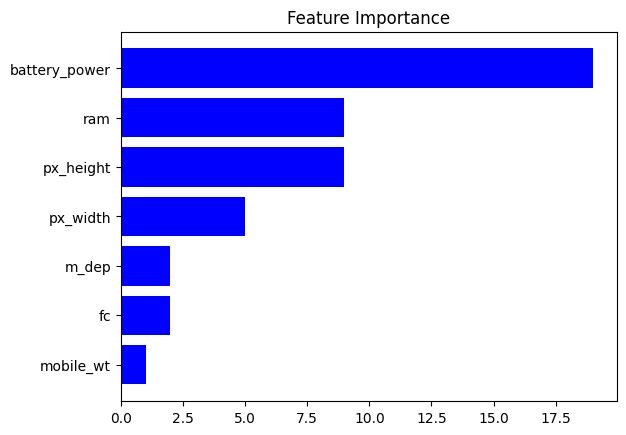

In [14]:
# first, we count the number of appearances of each features
feat_idxs, cnt = np.unique(clf_depth10.feat_list, return_counts=True)
# and then sort them by number of appearances
feat_idxs = feat_idxs[np.argsort(cnt)]
cnt = cnt[np.argsort(cnt)]

# second, we select the feature name from datafrmae to form a new list, which is in the 
# order of number of appearances
feature = []
for idx in feat_idxs:
    feature.append(train_df.columns[idx])

# last, we draw our graph
plt.barh(feature, cnt, color='blue')
plt.title('Feature Importance')
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [15]:
class AdaBoost():
    def __init__(self, n_estimators):
                     # n_estimators = number of iterations = number of weak learners
        self.n_estimators = n_estimators
        self.alphas = [] # weights for weak classifiers
        self.clfs = [] # list of classifiers
    

    def fit(self, x_data, y_data):
        
        n_samples, n_features = x_data.shape
        
        # initialize the weights
        w = np.full(n_samples, (1/n_samples))
        
        # iterate through base learners
        for i in range(self.n_estimators):
            
            clf_depth1 = DecisionTree(criterion='gini', max_depth=1) # initialization
            self.clfs.append(clf_depth1)
            self.clfs[i].fit(x_data, y_data, sample_weight=w) # fitting
            pred = self.clfs[i].predict(x_data) # prediction
            
            
            # calculate the error and update w from misclassified case
            
            # pick the predictions' weights where pred!=y_data
            # x=1 if pred!=y_data
            miss = [int(x) for x in (pred != y_data)]
            error = np.dot(w, miss)

            # misclassified: pred*y_data=-1, correct: pred*y_data=1
            yh = [-1 if x == 1 else 1 for x in miss]

            # update alpha and data weight
            alpha = 0.5 * np.log((1 - error) / error)
            self.alphas.append(alpha)

            w = np.multiply(w, np.exp([-x * self.alphas[i] for x in yh]))

            # normalize data weights so that the sum of data weights is 1
            w = w / np.sum(w)

    
    def predict(self, x_data):
        pred = np.zeros(len(x_data))
        for i in range(len(self.clfs)):
            weak_pred = self.clfs[i].predict(x_data)
            weak_pred[weak_pred==0] = -1
            pred += self.alphas[i]*weak_pred
        
        pred = np.sign(pred)
        pred[pred<0] = 0
        return pred

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [16]:
clf_Ada_10 = AdaBoost(n_estimators=10)
clf_Ada_10.fit(x_train, y_train)
y_pred = clf_Ada_10.predict(x_test)

In [17]:
print('n_estimators=10')
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

n_estimators=10
Test-set accuarcy score:  0.95


In [18]:
clf_Ada_100 = AdaBoost(n_estimators=100)
clf_Ada_100.fit(x_train, y_train)
y_pred = clf_Ada_100.predict(x_test)

In [19]:
print('n_estimators=100')
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

n_estimators=100
Test-set accuarcy score:  0.9766666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [20]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators # The number of trees in the forest
        self.max_features = int(max_features) # The number of random select features to consider 
                                              # when looking for the best split
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.trees = [] # store each single tree
        
    def fit(self, x_data, y_data):
        self.trees = []
        
        for i in range(self.n_estimators):
            # boostrapping
            if self.boostrap:
                sample_idx = np.random.choice(len(x_data), size=len(x_data), replace=True)
            else:
                sample_idx = np.arrange((len(x_data)))
            tree = DecisionTree(criterion=self.criterion, 
                                max_depth=self.max_depth, 
                                n_features=self.max_features,
                                random=True)
            
            tree.fit(x_data[sample_idx], y_data[sample_idx])
            self.trees.append(tree)
            
            
    def predict(self, x_data):

        y_pred = np.zeros(len(x_data), dtype='int64')
        for i in range(len(self.trees)):
            y_pred += self.trees[i].predict(x_data)

        mask = (y_pred > (self.n_estimators / 2)) # mask is a 'True' or 'False' array
        y_pred[mask] = 1 # set elements in y_pred to 1 if its corresponding mask is 'True'
        y_pred[(mask == False)] = 0 # set elements in y_pred to 0 if its corresponding mask is 'False'
        return y_pred

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [21]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_10tree.fit(x_train, y_train)
y_pred = clf_10tree.predict(x_test)
print('n_estimators=10, test-set accuarcy score: ', accuracy_score(y_test, y_pred))

n_estimators=10, test-set accuarcy score:  0.9166666666666666


In [22]:
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))
clf_100tree.fit(x_train, y_train)
y_pred = clf_100tree.predict(x_test)
print('n_estimators=100, test-set accuarcy score: ', accuracy_score(y_test, y_pred))

n_estimators=100, test-set accuarcy score:  0.94


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [23]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

clf_random_features.fit(x_train, y_train)
print("n_estimators=10, max_features=sqrt(n_features), accuracy:", accuracy_score(clf_random_features.predict(x_test), y_test))

clf_all_features.fit(x_train, y_train)
print("n_estimators=10, max_features=n_features, accuracy:", accuracy_score(clf_all_features.predict(x_test), y_test))

n_estimators=10, max_features=sqrt(n_features), accuracy: 0.9166666666666666
n_estimators=10, max_features=n_features, accuracy: 0.96


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [24]:
def train_your_model(x, y):
    ## Define your model and training 
    my_model = AdaBoost(n_estimators=150)
    my_model.fit(x, y)
    return my_model

In [25]:
my_model = train_your_model(x_train, y_train)

In [26]:
y_pred = my_model.predict(x_test)
print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

Test-set accuarcy score:  0.9766666666666667


In [27]:
np.save('y_pred.npy', y_pred)

In [28]:
assert y_pred.shape == (500, )

AssertionError: 

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [ ]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")
